In [1]:
import calendar
from builtins import frozenset

import pandas as pd
import matplotlib.pyplot as plt
from pygmo import population
from websocket._http import proxy_info

from src.model.models import Surebet
import matplotlib.dates as mdates
from typing import List
import matplotlib
from src.repository.surebet_repository import SurebetRepository

### Código para gerar gráficos

In [120]:
def config_plot(plt: matplotlib.pyplot):
    # Defina o tamanho da figura (largura x altura) em polegadas
    largura_figura = 20  # Ajuste a largura
    altura_figura = 6    # Ajuste a altura
    plt.figure(figsize=(largura_figura, altura_figura))
    plt.xticks(rotation=90)

def plotar(df: pd.DataFrame, eixos: tuple, title='Gráfico de Surebet por data'):
    plt = matplotlib.pyplot
    config_plot(plt)
    plt.ylabel('Quantidade Surebet')
    plt.title(title)
    # df = df.query(f'{eixos[1]} != 0')
    # plt.scatter(df[f'{eixos[0]}'], df[f'{eixos[1]}'])
    plt.bar(df[f'{eixos[0]}'], df[f'{eixos[1]}'])

    for i, valor in enumerate(df[f'{eixos[1]}']):
        plt.text(i, valor + 0.1, str(valor), ha='center')
    
    plt.show()

In [3]:
repository = SurebetRepository()


Frequência por dia:
'D' ou '1D' para intervalos de um dia.

Frequência por hora:
'H' ou '1H' para intervalos de uma hora.

Frequência por minuto:
'T' ou '1T' para intervalos de um minuto.

Frequência por segundo:
'S' ou '1S' para intervalos de um segundo.

Frequência por semana:
'W' ou '1W' para intervalos de uma semana.

Frequência por mês:
'M' ou '1M' para intervalos de um mês (final do mês).

Frequência por trimestre:
'Q' ou '3M' para intervalos de trimestre.

Frequência por ano:
'Y' ou '1Y' para intervalos de um ano.

In [180]:
def list_to_dataframe(dados: List[Surebet]) -> pd.DataFrame:
    df = pd.DataFrame.from_records([vars(i) for i in dados])
    df = df[['game_id', 'bookmaker_key_OVER', 'bookmaker_key_UNDER', 'odd_OVER', 'odd_UNDER', 'last_update_OVER', 'last_update_UNDER', 'profit']]
    return df


def setar_intervalo_df(df: pd.DataFrame, interval: tuple, freq: str, is_monthly = False):
    """
    Define intervalos de tempo em um DataFrame com base em um range e uma frequência.

    Esta função recebe um DataFrame, um range de datas e uma frequência e cria uma nova coluna
    no DataFrame que associa cada registro a um intervalo de tempo correspondente.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados a serem processados.
        interval (tuple): Uma tupla que especifica o início e o fim do intervalo de datas no formato 'AAAA-MM-DD'.
        freq (str): Uma string que especifica a frequência para criar os intervalos de tempo, por exemplo, '1H' para 1 hora.

    Returns:
        None: A função modifica o DataFrame original, adicionando a coluna 'Intervalo' com os intervalos correspondentes.
    """
    
    # Definir os intervalos manualmente 
    intervalos = []
    if is_monthly:    
        for i in range(1, 13):
            last_day_month = calendar.monthrange(2023, i)[1]
            intervalos.extend(list(pd.date_range(start=f'2023-{i}-01', end=f'2023-{i}-{last_day_month}', freq=(str(last_day_month - 1)) + 'D')))
    else:
        intervalos = pd.date_range(start=f'{interval[0]}', end=f'{interval[1]}', freq=f'{freq}')
    
    # Arredondando os minutos com base nos segundos
    # df['last_update_OVER'] = df['last_update_OVER'].dt.round('T')  todo testano outras formas de arredondar, voltar esse código depois
    # df['last_update_OVER'] = df['last_update_OVER'].dt.floor('T')

    posicao = df.columns.get_loc('last_update_UNDER')  # Obtém o índice da coluna 'last_update_UNDER'
    
    # Criar uma nova coluna com o intervalo correspondente a cada registro
    df.insert(posicao, 'intervalo', pd.cut(df['last_update_OVER'], bins=intervalos))


In [179]:
from datetime import datetime

from enum import Enum

class IntervaloTemporal(Enum):
    MES = 1
    DIA = 2
    HORA = 3
    MINUTO = 4


class ConfigPlot:
    def __init__(self, intervalo, data_inicial, data_final):
        self.intervalo = intervalo
        self.mascara_data = self.get_mascara_data(intervalo)
        self.data_inicial = data_inicial
        self.data_final = data_final

    def get_mascara_data(self, intervalo):
        mes = ['M', '30D', '31D']
        if intervalo in mes:
            return '%m-%Y'
        elif 'D' in intervalo:
            return '%d-%m-%Y'
        elif 'H' in intervalo or 'T' in intervalo:
            return '%H:%M:%S'
        else:
            raise ValueError("Intervalo não suportado")

def criar_config_plot(intervalo, data_inicial, data_final):
    return ConfigPlot(intervalo, data_inicial, data_final)

def gerar_plot_surebet(config: ConfigPlot, intervalo: IntervaloTemporal, title=''):
    lista_surebet = repository.find_all_unique_between(config.data_inicial, config.data_final)
    df = list_to_dataframe(lista_surebet)
    setar_intervalo_df(df, (config.data_inicial, config.data_final), config.intervalo, is_monthly = (intervalo == IntervaloTemporal.MES))
    
    print(df.head(40).to_string())
    
    # Agrupando a quantidade de surebets pelo intervalo
    resultado = df.groupby('intervalo').size().reset_index(name='quantidade')
    df_to_plot = pd.DataFrame({'intervalo': resultado['intervalo'].apply(lambda x: x.left.strftime(config.mascara_data)), 'quantidade': resultado['quantidade']})
    
    # print(df_to_plot.head().to_string())
    
    if intervalo == IntervaloTemporal.HORA or intervalo == IntervaloTemporal.MINUTO:
        df_to_plot = pd.DataFrame({'intervalo': resultado['intervalo'].apply(lambda x: x.left.strftime(config.mascara_data) + ' - ' + x.right.strftime(config.mascara_data)), 'quantidade': resultado['quantidade']})

    # print(df_to_plot.head().to_string())
    if intervalo == IntervaloTemporal.MES:  # Somando os intervalos para não ficar com dois registros por mês ex: 01-01 e 31-01
        df_to_plot = df_to_plot.groupby('intervalo').sum().reset_index()
    
    plotar(df_to_plot, ('intervalo', 'quantidade'), title=title)


                             game_id bookmaker_key_OVER bookmaker_key_UNDER  odd_OVER  odd_UNDER    last_update_OVER                                   intervalo   last_update_UNDER    profit
0   2e2871c70a3f30f2b3af9ee6ffa7dfd1          UNIBET_EU            PINNACLE      2.28       1.91 2023-09-02 14:24:34  (2023-09-02 14:20:00, 2023-09-02 14:25:00] 2023-09-02 14:24:35  3.784330
1   c5605d72a41240caa5e15b938ccf6983            ONEXBET           MATCHBOOK      2.12       1.92 2023-09-02 14:02:34  (2023-09-02 14:00:00, 2023-09-02 14:05:00] 2023-09-02 14:00:10  0.746855
2   761b437b3ce155bdfb3edfd36d753975          MATCHBOOK            PINNACLE      2.30       1.88 2023-09-02 14:58:22  (2023-09-02 14:55:00, 2023-09-02 15:00:00] 2023-09-02 14:58:22  3.330250
3   9d343fa61fbd30d6cef647794ddd9e36          MATCHBOOK            PINNACLE      2.18       1.85 2023-09-02 14:13:19  (2023-09-02 14:10:00, 2023-09-02 14:15:00] 2023-09-02 14:11:11  0.074386
4   cc3c9975e90b11038a2bc2e5c31f0dbc         

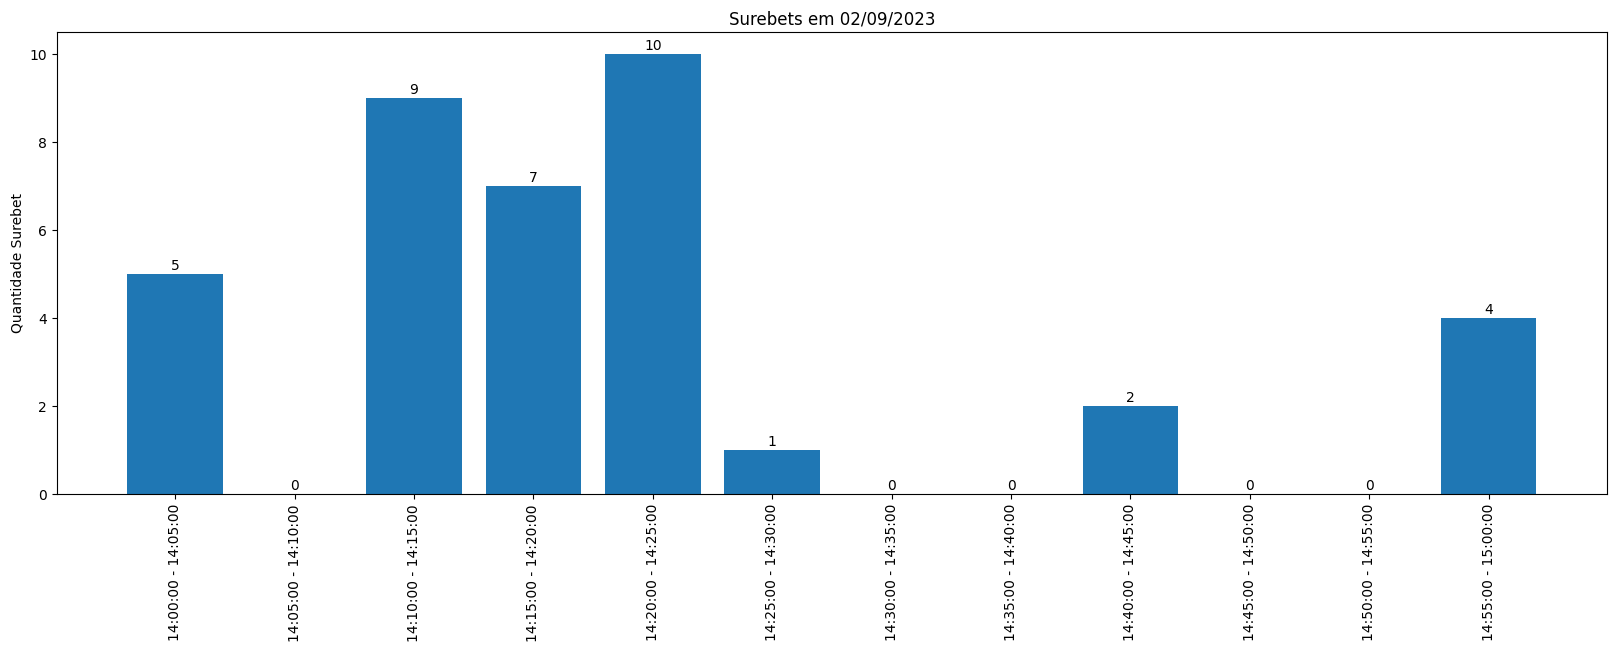

In [181]:
# meses = ConfigPlot('30D', '2023-01-01', '2023-12-31')
# gerar_plot_surebet(meses, intervalo=IntervaloTemporal.MES, title='Surebets identificadas em 2023')
# 
# dias = ConfigPlot('1D', '2023-09-01 00:00:00', '2023-09-30 23:59:59')
# gerar_plot_surebet(dias, intervalo=IntervaloTemporal.DIA, title='Surebets identificadas em Setembro')
# 
# horas = ConfigPlot('1H', '2023-09-02 00:00:00', '2023-09-02 23:59:59')
# gerar_plot_surebet(horas, intervalo=IntervaloTemporal.HORA, title='Surebets em 02/09/2023')

minutos = ConfigPlot('5T', '2023-09-02 14:00:00', '2023-09-02 15:00:00')
# minutos = ConfigPlot('5T', '2023-09-02 14:00:00', '2023-09-02 14:05:00')
gerar_plot_surebet(minutos, intervalo=IntervaloTemporal.MINUTO, title='Surebets em 02/09/2023')

In [ ]:
dias = ConfigPlot('1D', '2023-08-01 00:00:00', '2023-08-31 23:59:59')
horas = ConfigPlot('1H', '2023-08-26 00:00:00', '2023-08-26 23:59:59')
minutos = ConfigPlot('5T', '2023-09-01 19:00:00', '2023-09-01 20:00:00')
gerar_plot_surebet(dias, False)
gerar_plot_surebet(horas, False)

In [1]:
from src.genetic.arbitrage import Population
from src.util import PickleSerializer


# path = 'src/fatorial2k/monografia/params_definition/2023_11_08_[20:02:26]_efc7c/pickle.pkl'
path = 'src/fatorial2k/monografia/params_definition/2023_11_08_[20:02:18]_4a2c6/pickle.pkl'
population: Population = PickleSerializer.load(path)


In [2]:
import pygmo as pg


reference_point = [1.05, 1.05]
x_values = [x for x, _ in population.pareto_history_front_normalized]
y_values_reversed = [1 / pg.hypervolume([i for i in y]).compute(reference_point) for _, y in
                     population.pareto_history_front_normalized]

title = f'Population: {population.n_individuals} Mutation: {population.mutation_rate}'

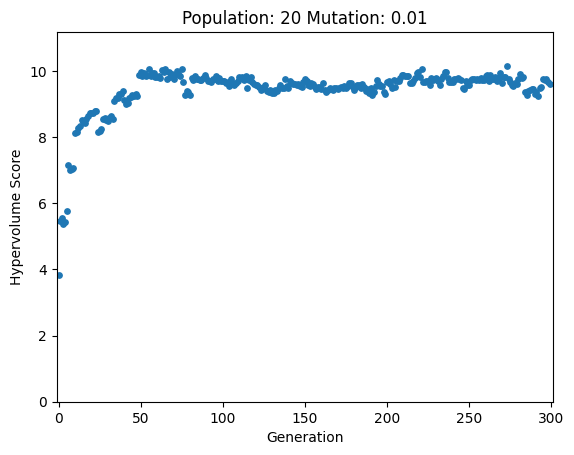

In [3]:
import matplotlib

plt = matplotlib.pyplot
plt.xlabel('Generation')
plt.ylabel('Hypervolume Score')
plt.title(title)
plt.xlim(-1, max(x_values) + 2)
plt.ylim(0, (max(y_values_reversed) * 1.1))
plt.scatter(x_values, y_values_reversed, s=15)


0.840277854959711 0.8152401381635863


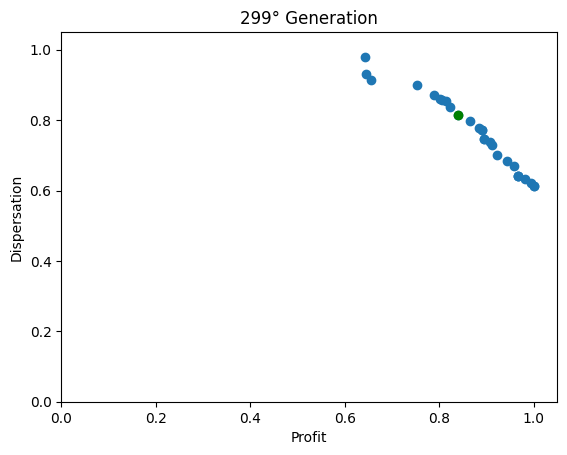

In [12]:
import matplotlib

def p(x, y, generation, index):
    plt = matplotlib.pyplot
    plt.figure()
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.title(f'{generation}° Generation')
    plt.xlabel('Profit')
    plt.ylabel('Dispersation')
    plt.scatter(x, y)
    plt.scatter(x[index], y[index], color='green')


x_data = []
y_data = []
for generation, front in population.pareto_history_front_normalized:
    x = [i[0] for i in front]
    y = [i[1] for i in front]
    if generation == population.n_generations - 1:
    # if generation == 0 or generation == population.n_generations - 1:
    # if generation == 0:
        index = 4
        p(x, y, generation, index)
        print(x[index], end=' ')
        print(y[index])

14
(0.895315365379272, 0.7471324589096361)


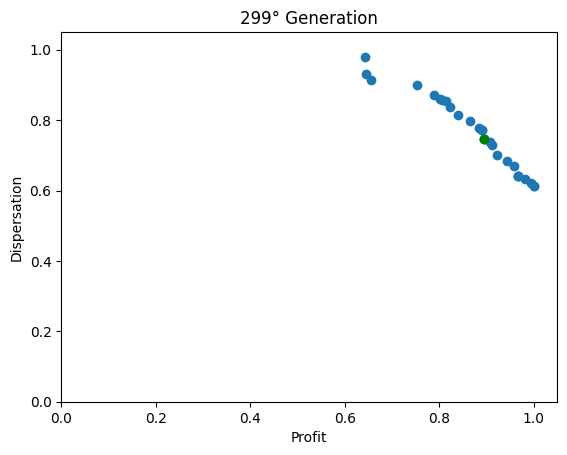

In [45]:

    
fronteira = population.pareto_history_front_normalized[-1][1]

ordenado = sorted(fronteira, key=lambda x: (x[0], x[1]))
x = [i[0] for i in ordenado]
y = [i[1] for i in ordenado]
print(len(ordenado)//2)
index = len(ordenado)//2
gene = ordenado[len(ordenado)//2]
print(gene)
p(x, y, 299, index)

14
28
28
3


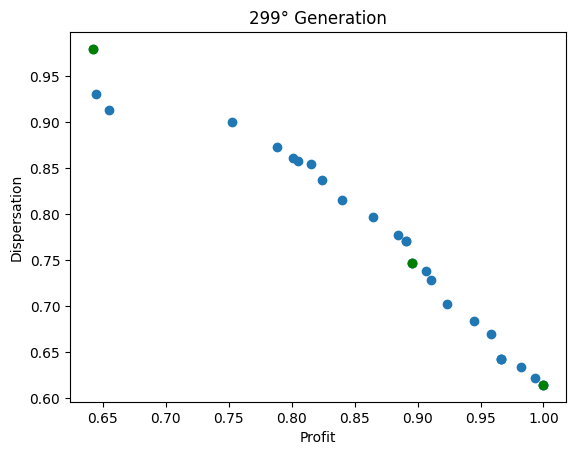

In [67]:
def paretos_frontier_plot(front, selected_individuals):
    plt = matplotlib.pyplot
    plt.figure()
    plt.xlim(0, 1.05)
    # plt.ylim(0, 1.05)
    plt.title(f'{generation}° Generation')
    plt.xlabel('Profit')
    plt.ylabel('Dispersation')
    plt.scatter([i.fitness_normalized[0] for i in front], [i.fitness_normalized[1] for i in front])
    plt.scatter([i.fitness_normalized[0] for i in selected_individuals], [i.fitness_normalized[1] for i in selected_individuals], color='green')
    
def pick_up_individuals(front):
    OPTIMIZE_PROFIT = -1
    OPTIMIZE_DISPERSATION = 0
    OPTIMIZE_MIDDLE = (len(front) // 2)
    print(OPTIMIZE_MIDDLE)
    print(len(front))
    front_sorted = sorted(front, key=lambda x: x.fitness[0])
    individuals_selected = front_sorted[OPTIMIZE_PROFIT], front_sorted[OPTIMIZE_DISPERSATION], front_sorted[OPTIMIZE_MIDDLE]
    return front_sorted, individuals_selected

def normalize(front):
    # max_profit = front[0].high_fitness_evaluated[0]
    # max_dispersation = front[0].high_fitness_evaluated[1]
    for i in front:
        profit_normalized = i.fitness[0] / max_profit
        dispersation_normalized = i.fitness[1] / max_dispersation
        i.fitness_normalized = [profit_normalized, dispersation_normalized]
            
frontier = population.pareto_history_front[299][1]
front_sorted, individuals_selected = pick_up_individuals(frontier)
print(len(front_sorted))
print(len(individuals_selected))
normalize(front_sorted)
normalize(individuals_selected)
paretos_frontier_plot(front_sorted, individuals_selected)
    

In [38]:
for i in population.pareto_history_front[0][1]:
    print(i.fitness)
    
resultado = sorted(population.pareto_history_front[0][1], key=lambda x: x.fitness[0], reverse=True)
print(resultado)

[271.03999999999996, 2.7300266863562244]
[644.82, 2.5380796312484613]
[565.47, 2.547418909997767]
[659.26, 2.2971850011066226]
[534.02, 2.5686050871669774]
[761.81, 1.5830689115989398]
[<src.genetic.arbitrage.Individual object at 0x7efebd9f2590>, <src.genetic.arbitrage.Individual object at 0x7efebd9f2170>, <src.genetic.arbitrage.Individual object at 0x7efebd9f20e0>, <src.genetic.arbitrage.Individual object at 0x7efebd9f2110>, <src.genetic.arbitrage.Individual object at 0x7efebd9f22f0>, <src.genetic.arbitrage.Individual object at 0x7efebdc2dc60>]


In [39]:
for i in resultado:
    print(i.fitness)

[761.81, 1.5830689115989398]
[659.26, 2.2971850011066226]
[644.82, 2.5380796312484613]
[565.47, 2.547418909997767]
[534.02, 2.5686050871669774]
[271.03999999999996, 2.7300266863562244]


In [46]:
def select_individuals(front):
    
    lucro = sorted(front, key=lambda x: x.fitness[0], reverse=True)[0]  # ordena pelo lucro
    distribuicao = sorted(front, key=lambda x: x.fitness[1], reverse=True)[0]  # ordena pela distribuição
    meio = front[len(front)//2]
    print(lucro.fitness)
    print(distribuicao.fitness)
    print(meio.fitness)

select_individuals(population.pareto_history_front[-1][1])

[899.75, 2.03036344106219]
[577.62, 3.237408686471487]
[819.6999999999999, 2.4085497597750996]


In [47]:
print([i.fitness for i in population.pareto_history_front[-1][1]])

[[899.75, 2.03036344106219], [577.62, 3.237408686471487], [677.38, 2.973545785888817], [778.04, 2.6336356575212063], [756.04, 2.695181697457845], [589.2800000000001, 3.0175402255033976], [830.78, 2.3199693294985244], [580.27, 3.0750242869202857], [862.5799999999999, 2.2116032725910673], [849.87, 2.261229762414852], [883.76, 2.093968039193538], [741.17, 2.7662254240904005], [795.47, 2.570432846032742], [733.37, 2.8247197110975133], [819.6999999999999, 2.4085497597750996], [815.76, 2.4386678018847254], [720.46, 2.8464898152309877], [869.32, 2.122422244556399], [894.02, 2.056552193604362], [709.3, 2.8852762029962555], [805.5600000000001, 2.4700178935815176], [801.23, 2.548631685914836], [724.65, 2.834111949062157], [869.32, 2.122422244556399], [805.5600000000001, 2.4700178935815176], [899.75, 2.03036344106219], [801.23, 2.548631685914836], [869.32, 2.122422244556399]]


In [63]:
profit_list = []
dispersation_list = []
for generation, front in population.pareto_history_front:
    profit_list.extend([i.fitness[0] for i in front])
    dispersation_list.extend([i.fitness[1] for i in front])

max_profit = max(profit_list)
max_dispersation = max(dispersation_list)
print(max_profit)
print(max_dispersation)

899.75
3.3059973022538167


In [18]:
# print(population.pareto_history_front[0][1])
lista = list()
for i in population.pareto_history_front[0][1]:
    # print([j.profit for j in i.arbitrages])
    # print(i.chromosome)
    print(i.fitness)
    profit = i.fitness[0] / max_profit
    dispersation = i.fitness[1] / max_dispersation
    lista.append((profit, dispersation))

# print(population.pareto_history_front_normalized[0])
# print(lista)
# print(population.pareto_history_front[0][1][0].profits)

[271.03999999999996, 2.7300266863562244]
[644.82, 2.5380796312484613]
[565.47, 2.547418909997767]
[659.26, 2.2971850011066226]
[534.02, 2.5686050871669774]
[761.81, 1.5830689115989398]
